# EXPLORED EDA - TIME SERIES

## IMPORTS

In [1]:
#  CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                 # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import warnings                   # Warning control and suppression

#  VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools

#  STATS: TIME-SERIES DECOMPOSITION & DIAGNOSTICS
from statsmodels.tsa.seasonal import seasonal_decompose         # Decompose time-series into trend, seasonal, and residual components
from statsmodels.tsa.stattools import acf                       # Compute autocorrelation values  
from statsmodels.tsa.stattools import pacf                      # Compute partial autocorrelation values  
from statsmodels.tsa.stattools import adfuller                  # Dickey-Fuller test for stationarity evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # Plot ACF & PACF with confidence bands
from statsmodels.stats.diagnostic import acorr_ljungbox         # Ljung-Box test for checking residual autocorrelation (model adequacy)
from statsmodels.tools.sm_exceptions import ConvergenceWarning  # Specific statsmodels warning for optimizer non-convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress convergence warnings globally (keeps logs clean)

#  TIME-SERIES MODELS (ARIMA)
from statsmodels.tsa.arima.model import ARIMA  # ARIMA(p,d,q) model for forecasting

#  AUTO-ARIMA (AUTOMATED MODEL SELECTION)
from pmdarima import auto_arima  # Automatic selection of ARIMA/SARIMA parameters (p,d,q,P,D,Q,m)

# SAVE MODELS
from pickle import dump

## HELPER FUNCTIONS

In [2]:
def log(message: str, level: int = 1, type: str = "INFO", custom_icon: str = None, bold: bool = False):
    # Default icons according to message type
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }
    # Use custom icon if provided
    if custom_icon:
        icon = custom_icon
    else:
        icon = icons.get(type.upper(), "ℹ️")
    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"
    # First level → bullet
    if level == 1:
        prefix = "•"
    # Second level → indent + hyphen
    elif level == 2:
        prefix = "   -"
    # Level 3 → deeper indent + middle dot
    elif level == 3:
        prefix = "      ·"
    # Fallback
    else:
        prefix = "-"
    # Final print
    print(f"{prefix} {icon} {message}")

# Determines granularity given seconds
def determine_granularity(seconds: float):
    if seconds < 1:
        granularity = "sub-second"
    elif seconds >= 1 and seconds < 60:
        granularity = "second"
    elif seconds >= 60 and seconds < 3600:
        granularity = "minute"
    elif seconds >= 3600 and seconds < 86400:
        granularity = "hour"
    elif seconds == 86400:
        granularity = "day"
    elif seconds > 86400 and seconds <= 86400 * 7:
        granularity = "multi-day"
    elif seconds == 86400 * 7:
        granularity = "week"
    elif seconds > 86400 * 7 and seconds < 86400 * 28:
        granularity = "weekly-to-monthly"
    elif seconds >= 86400 * 28 and seconds <= 86400 * 31:
        granularity = "month"
    elif seconds > 86400 * 31 and seconds <= 86400 * 92:
        granularity = "quarter"
    else:
        granularity = "year-or-more"
    return granularity

# Detects whether the seasonal decomposition model should be
# 'additive' (constant amplitude) or 
# 'multiplicative'(amplitude grows with the trend)
def infer_seasonal_component_type(series: pd.Series, threshold: float) -> str:
    # Compute amplitude and mean
    amplitude = series.max() - series.min()
    mean_val = series.mean()
    # Edge case: zero-mean → multiplicative impossible
    if mean_val == 0:
        return "additive"
    # Threshold for deciding multiplicative
    if amplitude / abs(mean_val) > threshold:
        return "multiplicative"
    else:
        return "additive"

#  Detects seasonality period automatically using the first significant ACF peak
def infer_period_from_acf(series: pd.Series, max_lag_ratio: float = 0.1):
    n = len(series)
    max_lag = max(5, int(n * max_lag_ratio))
    # Compute autocorrelation using FFT
    autocorr = acf(series, nlags=max_lag, fft=True, missing="drop")
    # Ignore lag 0
    autocorr[0] = 0
    # Find the highest correlation peak
    peak_lag = np.argmax(autocorr)
    # If the peak is too low → no seasonality
    if autocorr[peak_lag] < 0.3:
        return None
    return peak_lag

#  Detects seasonality period automatically using Granularity (fallback when ACF fails or data is too noisy)
def infer_period_from_granularity(granularity: str):
    if granularity == "sub-second":
        return None
    if granularity == "second":
        return 60
    if granularity == "minute":
        return 60
    if granularity == "hour":
        return 24
    if granularity == "day":
        return 7  # Most common weekly cycle IF the series shows any seasonality
    if granularity == "multi-day":
        return 7
    if granularity == "week":
        return 52
    if granularity == "weekly-to-monthly":
        return 12
    if granularity == "month":
        return 12
    if granularity == "quarter":
        return 4
    return None # Yearly or undefined → no decomposition

# 6) Evaluates how strong the seasonality is using:
# 1) Variance ratio: Var(seasonal) / Var(original)
# 2) ACF at the seasonal period
def assess_seasonality_strength(original: pd.Series, seasonal: pd.Series, period: int, acf_threshold: float, var_ratio: float):
    # Align indices and remove NaN values from the seasonal component
    valid_mask = seasonal.notna()
    original_valid = original[valid_mask]
    seasonal_valid = seasonal[valid_mask]
    # If there are not enough valid points → cannot assess
    if len(original_valid) < max(10, period * 2):
        metrics = {
            "seasonal_var_ratio": np.nan,
            "acf_at_period": np.nan
        }
        return False, metrics
    # 1) Variance ratio
    total_var = np.var(original_valid)
    seasonal_var = np.var(seasonal_valid)
    if total_var == 0:
        seasonal_var_ratio = 0.0
    else:
        seasonal_var_ratio = seasonal_var / total_var
    # 2) ACF at seasonal period
    acf_values = acf(
        original_valid,
        nlags = period,
        fft = True,
        missing = "drop"
    )
    acf_at_period = acf_values[period]
    # 3) Decision rule
    strong_seasonality = ((seasonal_var_ratio >= var_ratio) and (acf_at_period >= acf_threshold))
    # 4) Metrics
    metrics = {
        "seasonal_var_ratio": seasonal_var_ratio,
        "acf_at_period": acf_at_period
    }
    return strong_seasonality, metrics

# Performs Dickey-Fuller test to determine if a series is stacionary or not
def test_stationarity(series):
    dftest = adfuller(series, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

# Recursively differences the time-series until Dickey-Fuller test accepts stationarity (p < alpha)
def make_stationary_recursive(series, alpha: float = 0.05, max_diff: int = 5):
    current_series = series.copy()
    diff_count = 0
    while diff_count <= max_diff:
        test_results = test_stationarity(current_series)
        if test_results["p-value"] < alpha:
            return current_series, diff_count, test_results
        current_series = current_series.diff().dropna()
        diff_count += 1
    # If exceeded max_diff → return last attempt
    return current_series, diff_count, test_results

# Function to get recommended lag based on granularity
def get_recommended_lag(granularity):
    if granularity == "sub-second" or granularity == "second":
        return 600   # Captures 10 minutes of autocorrelation
    if granularity == "minute":
        return 300   # Captures 5 hours
    if granularity == "hour":
        return 200   # Captures up to weekly cycles (168h)
    if granularity == "day":
        return 60    # Enough for weekly + monthly seasonality
    if granularity == "multi-day":
        return 60
    if granularity == "week":
        return 60    # Enough to detect annual cycle (52 weeks)
    if granularity == "month":
        return 48    # Captures 4 years of monthly pattern
    if granularity == "quarter":
        return 20
    return 10        # Yearly or undefined → very small possible lags

# Function to get recommended cutoff for short-lag autocorrelation detection based on granularity
def get_short_lag_cutoff(granularity):
    if granularity == "sub-second" or granularity == "second":
        return 30   # 30 seconds of persistence
    if granularity == "minute":
        return 60   # 1 hour of short-term memory
    if granularity == "hour":
        return 24   # One day's worth of lags
    if granularity == "day":
        return 14   # Two weeks → enough to detect trend
    if granularity == "multi-day":
        return 10
    if granularity == "week":
        return 8    # ~2 months of weekly persistence
    if granularity == "month":
        return 12   # 1 year of autocorrelation
    if granularity == "quarter":
        return 8
    return 3        # Very limited short-term interpretation

# Return a pandas-compatible frequency string based on granularity
def get_freq_from_granularity(granularity: str):
    freq_map = {
        "sub-second": None,             # No valid pandas freq for < 1 second
        "second": "S",                  # Second-level frequency
        "minute": "T",                  # Minute-level frequency
        "hour": "H",                    # Hourly frequency
        "day": "D",                     # Daily frequency
        "multi-day": "D",               # Best stable approximation
        "week": "W",                    # Weekly frequency
        "weekly-to-monthly": "W",       # Ambiguous → weekly fits more stable
        "month": "M",                   # Monthly frequency
        "quarter": "Q",                 # Quarterly frequency
        "year-or-more": "A"             # Annual frequency
    }
    if granularity not in freq_map:
        return None
    return freq_map[granularity]

# Get seasonal period m for auto_arima
def get_auto_arima_m(period: int, seasonal_peaks: list):
    if period is None:
        return 1
    if seasonal_peaks is None:
        return 1
    if len(seasonal_peaks) == 0:
        return 1
    if period >= 2:
        return int(period)
    return 1

## STEP 0 - LOAD RAW DATAFRAME

In [3]:
# Raw dataset formatting
data_separator = ","
input_path = "../data/raw/internal-link.csv"
# Thresholds for dataset type proposal (NLP)
min_text_avg_length = 25      # Recommended: 20–30 chars → typical minimum for real text
min_text_avg_words  = 3       # Recommended: >3 words → avoids titles/labels
# Thresholds for dataset type proposal (Time-Series)
min_rows_in_dataset = 75      # Recommended: > 75
max_numeric_var = 5           # More than 5 is odd for a time-series
freq_ratio_threshold = 0.7    # Recommended: > 0.7 (values from 0 to 1)
# Plotting
figHeight_unit = 8
figWidth_unit = 12
plot_tick_font_size = 15
plot_label_font_size = 15
plot_text_font_size = 20
plot_title_font_size = 30


In [4]:
print("STEP 0) LOAD RAW DATAFRAME")

# Load raw DataFrame
df_raw = pd.read_csv(input_path, sep=data_separator)
log("DataFrame loaded successfully!", type="SUCCESS")

# ---------------------------------------------------------
# NLP CHECKING (probabilistic)
# ---------------------------------------------------------
log("NLP cheking:", custom_icon="📝")
nlp_score = 0            # Final probability score (0–100)
nlp_diag = []            # Diagnostic report

# Evidence 1: dataset has at least one text-like column
object_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype in ["object", "category"]:
        object_cols.append(col)
if len(object_cols) >= 1:
    nlp_score += 25
    log(f"Object-type columns found: {object_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No object-type columns found", level=2, type="ERROR")

# Evidence 2: long text columns exist
text_cols = []
for col in object_cols:
    avg_len = df_raw[col].dropna().str.len().mean()
    if avg_len is not None and avg_len > min_text_avg_length:
        text_cols.append(col)
if len(text_cols) >= 1:
    nlp_score += 25
    log(f"Long text-like columns found: {text_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 3: rich text structure (words per entry)
rich_text_cols = []
for col in text_cols:
    avg_words = df_raw[col].dropna().str.split().str.len().mean()
    if avg_words is not None and avg_words > min_text_avg_words:
        rich_text_cols.append(col)
if len(rich_text_cols) > 0:
    nlp_score += 25
    log(f"At least one column shows word-rich entries -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No column shows word-rich entries", level=2, type="ERROR")

# Evidence 4: number of text columns realistic for NLP
if len(text_cols) == 1:
    nlp_score += 15
    log(f"There is only 1 long text-like column, it is typical for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
elif len(text_cols) > 1:
    nlp_score += 5
    log(f"There are more than 1 long text-like column, it could be possible for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 5: proportion of non-empty text entries
if len(text_cols) >= 1:
    non_empty_ratio = df_raw[text_cols[0]].dropna().str.len().gt(10).mean()
    if non_empty_ratio >= 0.6:
        nlp_score += 10
        log(f"Majority of rows contain meaningful text -> + {nlp_score}%", level=2, type="SUCCESS")
    else:
        log("Too many empty/short text entries", level=2, type="ERROR")

# Cap score at 100
nlp_score = min(nlp_score, 100)
log(f"Probability score to be a NLP Dataset: {nlp_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# TIME-SERIES CHECKING (probabilistic)
# ---------------------------------------------------------
log("TIME-SERIES checking:", custom_icon="⏱️")
ts_score = 0                  # Final probability score (0–100)
ts_cols = []                  # List of detected datetime columns
ts_main_col = None            # Main datetime column chosen
ts_diag = []                  # Diagnostic list

# ---------------------------------------------------------
# Evidence 1) Detect datetime columns (robust)
# ---------------------------------------------------------
# Try to parse every column → if successful → datetime candidate
for col in df_raw.columns:
    try:
        pd.to_datetime(df_raw[col], errors="raise")
        ts_cols.append(col)
    except:
        pass

# Case 1 → no datetime columns
if len(ts_cols) == 0:
    log("No datetime columns detected", level=2, type="ERROR")
# Case 2 → exactly one column
elif len(ts_cols) == 1:
    ts_score += 40
    ts_main_col = ts_cols[0]
    log(f"Unique datetime column detected: {ts_main_col} -> + {ts_score}%", level=2, type="SUCCESS")
# Case 3 → multiple datetime columns
elif len(ts_cols) > 1:
    ts_score += 25
    ts_main_col = ts_cols[0]
    log(f"Several datetime columns were detected: {ts_cols} -> + {ts_score}%", level=2, type="SUCCESS")
    # Check if all datetime columns share similar structure
    for col in ts_cols:
        try:
            dt_tmp = pd.to_datetime(df_raw[col], errors="coerce")
            missing_rate = dt_tmp.isna().mean()
            log(f"Column '{col}' parsed with missing rate: {missing_rate:.3f}", level=3, type="INFO")
        except:
            log(f"Column '{col}' failed advanced parsing", level=3, type="ERROR")

if ts_main_col is not None: # Evaluate time-series structure (only if datetime column exists)

    # Convert chosen datetime column
    serie_date_time_raw = pd.to_datetime(df_raw[ts_main_col], errors="coerce")

    # ---------------------------------------------------------
    # Evidence 2) Chronologically sorted
    # ---------------------------------------------------------
    if serie_date_time_raw.is_monotonic_increasing:
        ts_score += 20
        log(f"Datetime column '{ts_main_col}' is sorted -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log(f"Datetime column '{ts_main_col}' is NOT sorted", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 3) Detecting time-series frequency
    # ---------------------------------------------------------
    serie_date_time_diff_raw = serie_date_time_raw.diff().dropna()

    if len(serie_date_time_diff_raw) > 0:
        # Compute most common interval
        most_common_delta = serie_date_time_diff_raw.mode()[0]
        freq_ratio = (serie_date_time_diff_raw == most_common_delta).mean()
        if freq_ratio >= freq_ratio_threshold:
            ts_score += 20
            log(f"Regular frequency detected -> + {ts_score}%", level=2, type="SUCCESS")
            log(f"Frequency consistency ratio: {freq_ratio:.3f}", level=3, type="INFO")
        else:
            log("No regular frequency detected", level=2, type="ERROR")
    else:
        log("Not enough data to detect time-series frequency", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 4) Numeric columns over time
    # ---------------------------------------------------------
    numeric_cols = df_raw.select_dtypes(include=["number"]).columns
    if 1 <= len(numeric_cols) <= max_numeric_var:
        ts_score += 10
        log(f"Numeric variables suitable for TS -> + {ts_score}%", level=2, type="SUCCESS")
    elif len(numeric_cols) < 1:
        log("There is not at least one numeric variable for time-series", level=2, type="ERROR")
    else:
        log("Too many numeric varaibles for time-series", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 5) Dataset length
    # ---------------------------------------------------------
    if len(df_raw) >= min_rows_in_dataset:
        ts_score += 10
        log(f"Enough rows for time-series -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Dataset too short for time-series", level=2, type="ERROR")

# Cap score at 100
ts_score = min(ts_score, 100)

log(f"Probability score to be a TIME-SERIES Dataset: {ts_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# Dataset type proposal
# ---------------------------------------------------------
if ts_score >= nlp_score and ts_score >= 75:
    dataset_type_auto = "TIME-SERIES"
elif nlp_score >= ts_score and nlp_score >= 75:
    dataset_type_auto = "NLP"
else:
    dataset_type_auto = "TABULAR"
print("----------------------------------------")
log(f"Proposed dataset type: {dataset_type_auto}", type="INFO", bold=True)
print("----------------------------------------")

STEP 0) LOAD RAW DATAFRAME
• ✅ DataFrame loaded successfully!
• 📝 NLP cheking:
   - ✅ Object-type columns found: ['date'] -> + 25%
   - ✅ Long text-like columns found: ['date'] -> + 50%
   - ❌ No column shows word-rich entries
   - ✅ There is only 1 long text-like column, it is typical for NLP -> + 65%
   - ✅ Majority of rows contain meaningful text -> + 75%
   - ℹ️ Probability score to be a NLP Dataset: 75%
• ⏱️ TIME-SERIES checking:
   - ✅ Several datetime columns were detected: ['date', 'sales'] -> + 25%
      · ℹ️ Column 'date' parsed with missing rate: 0.000
      · ℹ️ Column 'sales' parsed with missing rate: 0.000
   - ✅ Datetime column 'date' is sorted -> + 45%
   - ✅ Regular frequency detected -> + 65%
      · ℹ️ Frequency consistency ratio: 1.000
   - ✅ Numeric variables suitable for TS -> + 75%
   - ✅ Enough rows for time-series -> + 85%
   - ℹ️ Probability score to be a TIME-SERIES Dataset: 85%
----------------------------------------
• ℹ️ Proposed dataset type: TIME-SERIES


## STEP 1 - EXPLORE DATAFRAME

In [5]:
dataset_type = "TIME-SERIES" # Confirm dataset type (TIME-SERIES, NLP or TABULAR)
ts_main_col_index = 0 # Needed if TIME-SERIES is selected

In [6]:
print("STEP 1) EXPLORE DATAFRAME")

# Copy original DataFrame
df_S1 = df_raw.copy()

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    log("Dataset detected as NLP (long-text dataset)", custom_icon="📝")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Sample of raw text entries:", type="INFO")
    display(df_S1[text_cols].head(5))

    # Print text length stats
    df_S1_lengths = df_S1[text_cols[0]].astype(str).str.len()
    log("Text length statistics:", type="INFO")
    log(f"Average lengths: {df_S1_lengths.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median lengths: {df_S1_lengths.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max lengths: {df_S1_lengths.max():.1f} chars", level=2, custom_icon="📊")

    # Compute word statistics
    df_S1_words = df_S1[text_cols[0]].astype(str).str.split().str.len()
    log("Word count statistics:", type="INFO")
    log(f"Average words: {df_S1_words.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median words: {df_S1_words.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max words: {df_S1_words.max():.1f} chars", level=2, custom_icon="📊")

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    log("Dataset detected as TIME-SERIES", custom_icon="⏱️")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))

    # Try to parse every column
    df_S1_ts_cols = []
    for col in df_S1.columns:
        try:
            pd.to_datetime(df_S1[col], errors="raise")
            df_S1_ts_cols.append(col)
        except:
            pass

    # Time column
    df_S1_ts_main_col = df_S1_ts_cols[ts_main_col_index]
    serie_date_time_S1 = pd.to_datetime(df_S1[df_S1_ts_main_col], errors="coerce")
    log("Time index information:", type="INFO")
    log(f"Detected time column: '{df_S1_ts_main_col}'", level=2, custom_icon="📅")
    log(f"Start date: {serie_date_time_S1.min()}", level=2, custom_icon="📅")
    log(f"End date: {serie_date_time_S1.max()}", level=2, custom_icon="📅")
    log(f"Total duration: {serie_date_time_S1.max() - serie_date_time_S1.min()}", level=2, custom_icon="📅")

    # Estimate frequency and granularity
    serie_date_time_diff_S1 = serie_date_time_S1.diff().dropna()
    if len(serie_date_time_diff_S1) > 0:
        df_S1_most_common_delta = serie_date_time_diff_S1.mode()[0] # Most common interval
        df_S1_smallest_delta = serie_date_time_diff_S1.min() # Minimal interval
        df_S1_freq_ratio = (serie_date_time_diff_S1 == df_S1_most_common_delta).mean()
        # Determine granularity
        df_S1_seconds = df_S1_most_common_delta.total_seconds()
        granularity = determine_granularity(df_S1_seconds)
        log(f"Most common interval: {df_S1_most_common_delta} (granularity: {granularity})", level=2, custom_icon="📅")
        log(f"Smallest interval: {df_S1_smallest_delta}", level=2, custom_icon="📅")
        log(f"Frequency consistency ratio: {df_S1_freq_ratio:.3f}", level=2, custom_icon="📅")
    else:
        log("Not enough data points to estimate frequency", type="WARNING")

    # Missing or irregular timestamps
    missing_ratio = 1 - (serie_date_time_diff_S1 == most_common_delta).mean() if len(serie_date_time_diff_S1) > 0 else None
    if missing_ratio is not None and missing_ratio > 0.10:
        log("Irregular timestamps detected (missing or uneven intervals)", type="WARNING")
        log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")

    # Numeric metrics
    numeric_cols = df_S1.select_dtypes(include=["number"]).columns
    log("Numeric metrics detected:", type="INFO")
    for col in numeric_cols:
        log(f"{col}", level=2, custom_icon="📈")

    # Statistics for each metric
    log("Basic statistics per numeric variable:", type="INFO")
    display(df_S1[numeric_cols].describe().T)

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    log("Dataset detected as TABULAR", custom_icon="🧮")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Info of the DataFrame (dataType and non-null values):", type="INFO")
    df_S1.info(verbose=True, show_counts=True)

    # Ordered info (fewest non-null first)
    ordered_info = pd.DataFrame({
        "Column": df_S1.columns,
        "Non-Null Count": df_S1.notnull().sum(),
        "Null Count": df_S1.isnull().sum(),
        "Dtype": df_S1.dtypes.astype(str)
    }).sort_values(by="Non-Null Count", ascending=True)
    log("Ordered info by number of non-null values:", type="INFO")
    display(ordered_info)

    # Count unique attributes (unsorted)
    df_S1_summary = pd.DataFrame({
        "Column": df_S1.columns,
        "Unique_Count": df_S1.nunique().values
    })
    log("DataFrame unique attributes (unsorted):", type="INFO")
    display(df_S1_summary)

    # Ordered summary (fewest unique first)
    df_S1_summary_ordered = df_S1_summary.sort_values(by="Unique_Count", ascending=True)
    log("Ordered unique attributes (fewest unique first):", type="INFO")
    display(df_S1_summary_ordered)

    # Automatic Warning for high-uniqueness columns
    unique_counts = df_S1.nunique()
    high_unique_cols = unique_counts[unique_counts == len(df_S1)].index.tolist()
    if len(high_unique_cols) > 0:
        log("Consider dropping the following columns for having UNIQUE values for EVERY row:", type="WARNING")
        for col in high_unique_cols:
            log(f"{col}", level=2, custom_icon="🗑️")

STEP 1) EXPLORE DATAFRAME
• ⏱️ Dataset detected as TIME-SERIES
• ℹ️ Shape of the DataFrame: (366, 2)
• ℹ️ Content of the DataFrame:


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


• ℹ️ Time index information:
   - 📅 Detected time column: 'date'
   - 📅 Start date: 2022-09-03 17:10:08.079328
   - 📅 End date: 2023-09-03 17:10:08.079328
   - 📅 Total duration: 365 days 00:00:00
   - 📅 Most common interval: 1 days 00:00:00 (granularity: day)
   - 📅 Smallest interval: 1 days 00:00:00
   - 📅 Frequency consistency ratio: 1.000
• ℹ️ Numeric metrics detected:
   - 📈 sales
• ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
sales,366.0,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


CONCLUSIONS:
- GRANULARITY: 1 day
- TOTAL DURATION: 365 days
- SMALLEST INTERVAL: 1day

## STEP 2 - BUILD TIME-SERIES

STEP 2) BUILD TIME-SERIES
• 🔍 Detected temporal column: 'date'
• ℹ️ Indexed DataFrame by 'date'
• ℹ️ Preview of time-indexed DataFrame:


,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


• ✅ Extracted target time-series 'sales'


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

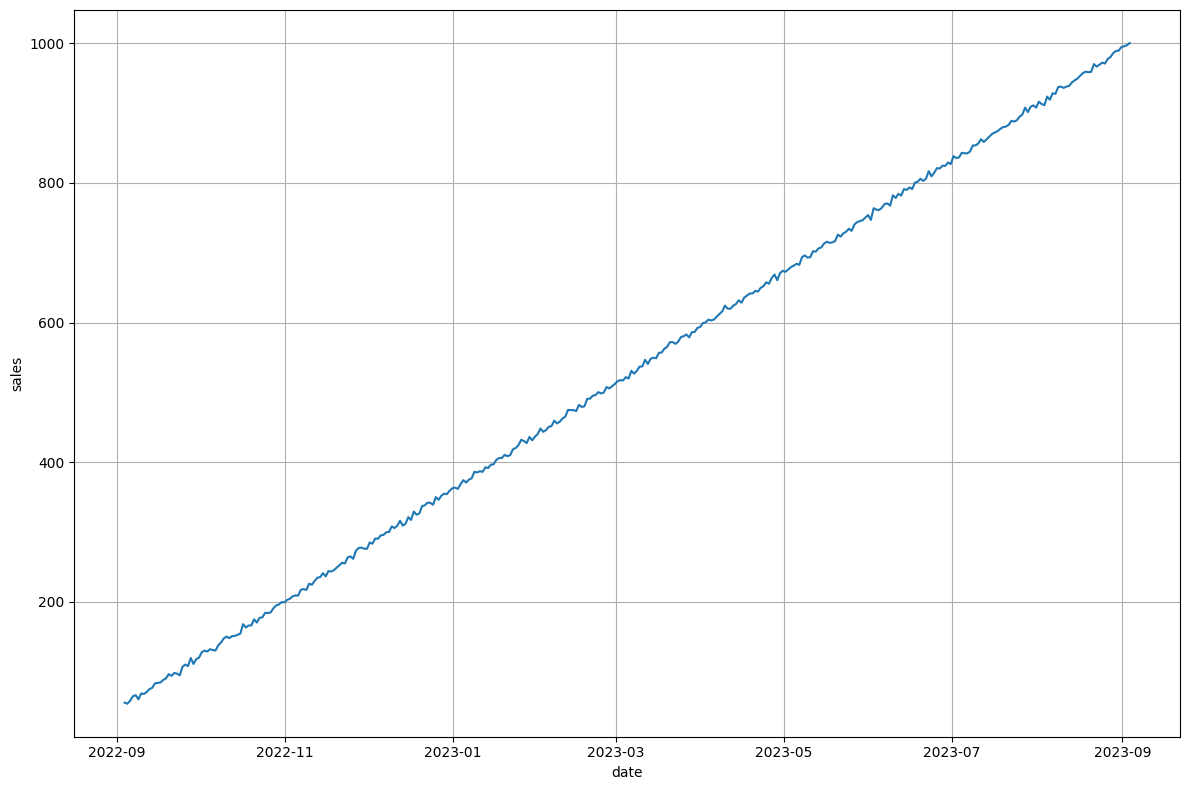

In [7]:

print("STEP 2) BUILD TIME-SERIES")

# Copy previous DataFrame
df_S2 = df_S1.copy()
df_S2_ts_main_col = df_S1_ts_main_col

if dataset_type == "TIME-SERIES":
    # Identify the temporal column
    if len(df_S2_ts_main_col) > 0:
        log(f"Detected temporal column: '{df_S2_ts_main_col}'", type="FOUND")
    else:
        log("No temporal column found → cannot build time index", type="ERROR")
        df_S2_ts_main_col = None
    # Stop if no datetime column exists
    if df_S2_ts_main_col is None:
        raise ValueError("No datetime column found → cannot build time index.")
    
    # Drop the column if still present as normal column
    if df_S2_ts_main_col in df_S2.columns:
        df_S2 = df_S2.drop(columns=[df_S2_ts_main_col])
    # Copy previous time-series
    serie_date_time_S2 = serie_date_time_S1.copy()
    # Sort by datetime just in case
    serie_date_time_S2 = serie_date_time_S2.sort_values()
    # Assign the datetime index
    df_S2.index = serie_date_time_S2
    # Make sure the index has a name
    df_S2.index.name = df_S2_ts_main_col
    # Show preview
    log(f"Indexed DataFrame by '{df_S2_ts_main_col}'", type="INFO")
    log("Preview of time-indexed DataFrame:", type="INFO")
    display(df_S2.head(5))

    # Extract numeric target series
    df_S2_numeric_cols = df_S2.select_dtypes(include=["number"]).columns
    if len(df_S2_numeric_cols) > 0:
        # Pick the first numeric column as the time-series
        df_S2_numeric_target_col = df_S2_numeric_cols[0]
        df_timeseries_S2 = df_S2[df_S2_numeric_target_col].dropna()

        log(f"Extracted target time-series '{df_S2_numeric_target_col}'", type="SUCCESS")
        display(df_timeseries_S2.head(5))
        fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
        sns.lineplot(data = df_timeseries_S2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        log("No numeric metrics detected to extract as the main time-series", type="ERROR")

CONCLUSIONS:
- TREND: seems ascendent
- SEASONAL: not clear

## STEP 3 - DECOMPOSE TIME-SERIES

In [8]:
# Threshold to determine seasonal component type (multiplicative or additive)
seasonal_component_type_threshold = 0.3 # if amplitude/abs(mean_val) > threshold -> "multiplicative"

# Thresholds to detect strong seasonal (both need to be higher than thresholds)
strong_seasonal_threshold_for_acf = 0.6 # ACF at the seasonal period
strong_seasonal_threshold_for_var_ratio = 0.5 # Variance ratio: Var(seasonal) / Var(original)

STEP 3) DECOMPOSE TIME-SERIES
• ✅ Timestamp regularity OK (freq_ratio=1.000)
• ✅ Seasonality detected via ACF → period = 1
• ✅ Type of seasonal component selected: multiplicative
• ✅ Decomposition completed successfully
• ⚠️ Weak or no seasonality (var_ratio=0.000, acf=0.992)


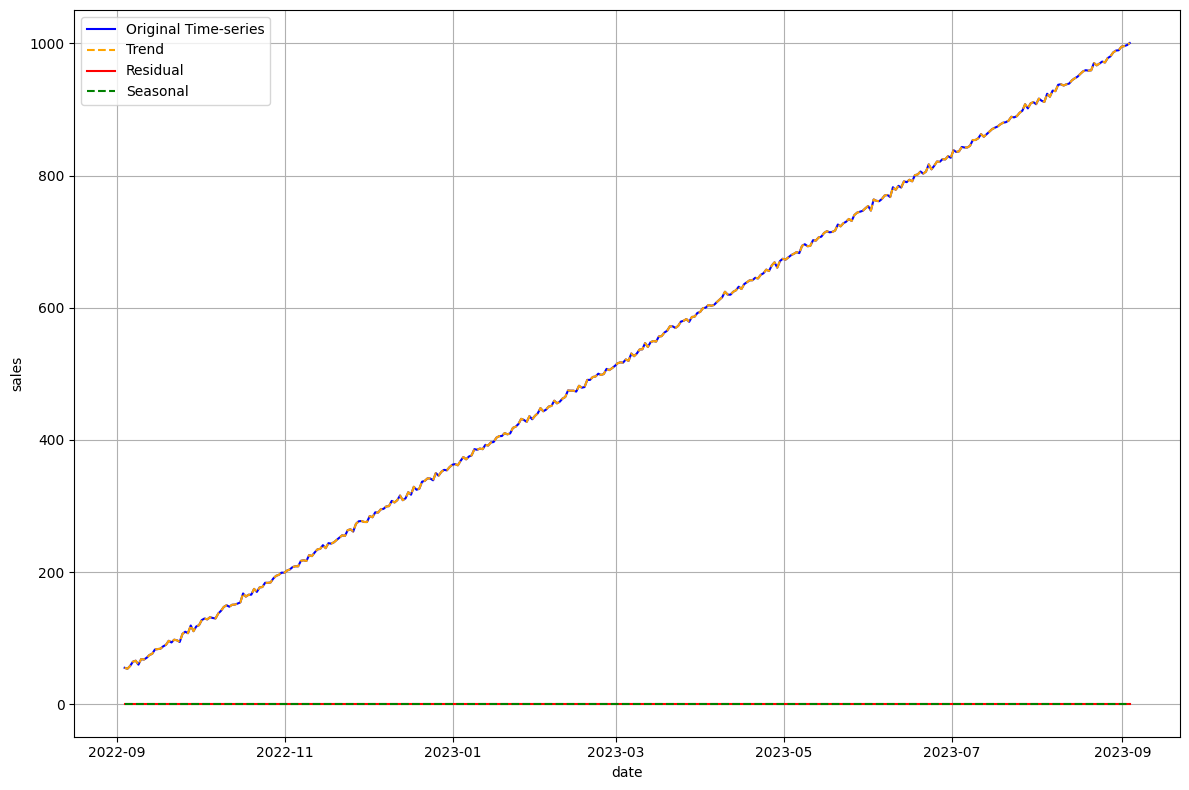

In [9]:
print("STEP 3) DECOMPOSE TIME-SERIES")

# Copy previous DataFrame and Series
df_timeseries_S3 = df_timeseries_S2.copy()
serie_date_time_S3 = serie_date_time_S2.copy()
df_S3_freq_ratio = df_S1_freq_ratio

# 1) Validate series regularity before decomposition
if df_S3_freq_ratio < freq_ratio_threshold:
    raise ValueError(f"Decomposition skipped due to Low frequency regularity (freq_ratio={df_S3_freq_ratio:.3f})")
log(f"Timestamp regularity OK (freq_ratio={df_S3_freq_ratio:.3f})", level=1, type="SUCCESS")

# 2) Detect period using ACF (primary robust method)
period_acf = infer_period_from_acf(df_timeseries_S3)
if period_acf is not None:
    period_S3 = period_acf
    log(f"Seasonality detected via ACF → period = {period_acf}", level=1, type="SUCCESS")
else:
    log("No significant seasonality found via ACF", level=1, type="WARNING")

    # 3) Fallback based on granularity (if ACF failed)
    period_fallback = infer_period_from_granularity(granularity)
    if period_fallback is None:
        raise ValueError("Unable to infer any valid period. Decomposition skipped because it is impossible to infer any valid period")
    log(f"Fallback period inferred: {period_fallback} (granularity={granularity})", level=1, type="SUCCESS")
    period_S3 = period_fallback

# 4) Determine model: additive or multiplicative
seasonal_component_type_S3 = infer_seasonal_component_type(df_timeseries_S3, seasonal_component_type_threshold)
log(f"Type of seasonal component selected: {seasonal_component_type_S3}", level=1, type="SUCCESS")

# 5) Perform decomposition
try:
    decomposition_S3 = seasonal_decompose(x=df_timeseries_S3, model=seasonal_component_type_S3, period=period_S3)
    trend_S3 = decomposition_S3.trend
    seasonal_S3 = decomposition_S3.seasonal
    residual_S3 = decomposition_S3.resid
    log("Decomposition completed successfully", level=1, type="SUCCESS")
except Exception as e:
    raise ValueError(f"Decomposition failed: {e}")

# 6) Compute seasonality strength metrics
strong_seasonality_S3, seasonality_metrics_S3 = assess_seasonality_strength(
    original        = df_timeseries_S3,
    seasonal        = seasonal_S3,
    period          = period_S3,
    acf_threshold   = strong_seasonal_threshold_for_acf,
    var_ratio       = strong_seasonal_threshold_for_var_ratio
)
if strong_seasonality_S3:
    log(f"Strong seasonality detected (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "SUCCESS")
else:
    log(f"Weak or no seasonality (var_ratio={seasonality_metrics_S3["seasonal_var_ratio"]:.3f}, acf={seasonality_metrics_S3["acf_at_period"]:.3f})", level = 1, type  = "WARNING")

# 7) Plot decomposition
fig, axis = plt.subplots(figsize = (figWidth_unit, figHeight_unit))
sns.lineplot(data = df_timeseries_S3, color = "blue", label = "Original Time-series")
sns.lineplot(data = trend_S3, color = "orange", label = "Trend", linestyle = "--")
sns.lineplot(data = residual_S3, color = "red", label = "Residual")
sns.lineplot(data = seasonal_S3, color = "green", label = "Seasonal", linestyle = "--")
plt.grid(True)
plt.tight_layout()
plt.show()

CONCLUSIONS:
- TREND: confirmed ascendent
- SEASONAL: 1 day period

## STEP 4 - STACIONARY ANAYSIS

In [10]:
accepted_alpha_dickey_fuller = 0.05 # Accepted error in the hypothesis

In [11]:
print("STEP 4) STACIONARY ANAYSIS")

# Copy previous DataFrame and Series
df_timeseries_S4 = df_timeseries_S3.copy()

# Perform Dickey-Fuller test to check for stacionarity
series_Dickey_Fuller_results = test_stationarity(series=df_timeseries_S4)

if series_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
    log(f"Dickey-Fuller test's results:\n{series_Dickey_Fuller_results}\n", level=1, type="INFO")
    log(f"Hyphotesis rejected:Time-series IS NOT stationary, recursive differenciation is carried out\n", level=1, type="WARNING", bold = True)
    # Peform recursively Dickley-Fuller test until the time-series becomes stacionary
    df_stationary_timeseries_S4, diff_count_S4, series_recursive_Dickey_Fuller_results = make_stationary_recursive(
        series=df_timeseries_S4,
        alpha=accepted_alpha_dickey_fuller
        )
    log(f"Recursive differenciation ({diff_count_S4} step/s) -> Dickey-Fuller test's results:\n{series_recursive_Dickey_Fuller_results}\n", level=1, type="INFO")

    if series_recursive_Dickey_Fuller_results["p-value"] >= accepted_alpha_dickey_fuller:
        log(f"Time-series cannot become stationary (after {diff_count_S4} differencing step/s)", level=1, type="WARNING", bold = True)
    else:
        log(f"Time-series can become stationary (after {diff_count_S4} differencing step/s)", level=1, type="SUCCESS", bold = True)
else:
    diff_count_S4= 0
    log(f"Hyphotesis accepted: time-series IS stationary, no need of differenciation", level=1, type="SUCCESS", bold = True)


STEP 4) STACIONARY ANAYSIS
• ℹ️ Dickey-Fuller test's results:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

• ⚠️ Hyphotesis rejected:Time-series IS NOT stationary, recursive differenciation is carried out

• ℹ️ Recursive differenciation (1 step/s) -> Dickey-Fuller test's results:
Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

• ✅ Time-series can become stationary (after 1 differencing step/s)


## STEP 5 - VARIABILITY ANAYSIS

In [12]:
print("STEP 5) VARIABILITY ANALYSIS")

# Copy previous DataFrame and Series
residual_S5 = residual_S3.copy()
seasonal_component_type_S5 = seasonal_component_type_S3

# Drop NaN values in residuals
residual_S5 = residual_S5.dropna()
# -------------------------------------------
# RULE A: Check for visible trend in residuals
# -------------------------------------------
# Compute simple linear regression on residual vs time index
x_index = np.arange(len(residual_S5))
# Fit linear regression slope
slope, intercept = np.polyfit(x_index, residual_S5.values, 1)
# Compute residual standard deviation
residual_std = np.std(residual_S5)
# If residuals are almost constant → no trend by definition
if residual_std < 1e-8:
    log("Residual's slope analysis: Residuals are almost constant → no visible trend (good).", level=1, type="SUCCESS")
else:
    # Define a tolerance based on std and a minimum absolute tolerance
    if abs(slope) < max(residual_std * 0.01, 1e-6):
        log("Residual's slope analysis: No visible trend detected (good).", level=1, type="SUCCESS")
    else:
        log("Residual's slope analysis: Trend detected in residuals (bad).", level=1, type="WARNING", bold=True)

# -------------------------------------------
# RULE B: Check periodicity using ACF
# -------------------------------------------
# If residuals are almost constant → ACF cannot detect periodicity, assume GOOD
if residual_std < 1e-8:
    log("Residual's ACF analysis: Residuals are almost constant → no periodicity possible (good).", level=1, type="SUCCESS")
else:
    # Compute ACF up to 40 lags safely
    nlags = min(40, len(residual_S5) - 2)
    acf_res = acf(residual_S5, nlags=nlags, fft=True, missing="drop")
    # Detect highest non-zero lag correlation
    acf_res_no0 = acf_res[1:]
    max_acf_lag = np.argmax(np.abs(acf_res_no0)) + 1
    max_acf_value = acf_res[max_acf_lag]
    # Log ACF
    log(f"Residual ACF strongest lag={max_acf_lag}, value={max_acf_value:.3f}", level=1, type="INFO")
    # If ACF is NaN → cannot infer periodicity → assume GOOD
    if np.isnan(max_acf_value):
        log("Residual's ACF analysis: ACF cannot be computed reliably (likely constant residuals) → no periodicity detected (good).", level=1, type="SUCCESS")
    # Periodicity rule: if max ACF < 0.3 → no meaningful periodicity
    elif abs(max_acf_value) < 0.3:
        log("Residual's ACF analysis: No periodic patterns detected (good).", level=1, type="SUCCESS")
    else:
        log("Residual's ACF analysis: Residuals show periodic patterns (bad).", level=1, type="WARNING", bold=True)

# -------------------------------------------
# 4) RULE C: Check that residuals are centered
# -------------------------------------------
# Set theoretical center depending on decomposition model
residual_center = 1.0 if seasonal_component_type_S5 == "multiplicative" else 0.0
# Compute mean and standard deviation of cleaned residuals
mean_res = residual_S5.mean()
sd_res = residual_S5.std()
# Define relative and absolute tolerances
threshold_center = max(sd_res * 0.05, 1e-6)
# Center rule: mean close to the expected center (0 additive, 1 multiplicative)
if abs(mean_res - residual_center) < threshold_center:
    log(f"Residual's center analysis: Residuals centered around expected center ({residual_center}) (good).", level=1, type="SUCCESS")
else:
    log(f"Residual's center analysis: Residuals not centered around expected center ({residual_center}) (bad).", level=1, type="WARNING")

# -------------------------------------------
# 5) RULE D: Check for randomness using Ljung–Box test
# -------------------------------------------
# Center residuals for randomness tests
residual_S5_centered = residual_S5 - residual_center
# Compute standard deviation
sd_res_centered = residual_S5_centered.std()
# If residuals are almost constant → cannot test randomness, but constant noise = GOOD
if sd_res_centered < 1e-8:
    log("Residual's randomness analysis: Residuals are almost constant → randomness cannot be tested, assumed random (good).", level=1, type="SUCCESS")
else:
    # Define safe number of lags
    safe_lag = min(10, len(residual_S5_centered) - 2)
    # Compute Ljung–Box p-value
    ljung_box_p = acorr_ljungbox(residual_S5_centered, lags=[safe_lag], return_df=True)["lb_pvalue"].iloc[0]
    # Log p-value
    log(f"Ljung–Box p-value (lag {safe_lag}) = {ljung_box_p:.4f}", level=1, type="INFO")
    # Randomness rule: if p > 0.05 → residuals behave like white noise
    if ljung_box_p > 0.05:
        log("Residual's randomness analysis: Residuals behave as random noise (good).", level=1, type="SUCCESS")
    else:
        log("Residual's randomness analysis: Residuals show correlation → not white noise (bad).", level=1, type="WARNING")

STEP 5) VARIABILITY ANALYSIS
• ✅ Residual's slope analysis: Residuals are almost constant → no visible trend (good).
• ✅ Residual's ACF analysis: Residuals are almost constant → no periodicity possible (good).
• ✅ Residual's center analysis: Residuals centered around expected center (1.0) (good).
• ✅ Residual's randomness analysis: Residuals are almost constant → randomness cannot be tested, assumed random (good).


## STEP 6 - AUTOCORRELATION ANALYSIS

STEP 6) AUTOCORRELATION ANALYSIS
• ℹ️ Applied pandas frequency 'D' to series for ARIMA modeling.
• ℹ️ Used safe_lag = 60 (recommended=60, granularity=day)
• ℹ️ ACF analysis: Significant autocorrelation at lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60].
• ℹ️ ACF analysis: High short-lag autocorrelation → possible trend or strong persistence.
• ✅ ACF analysis: Significant seasonal peaks at lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60] → strong seasonality.
• ℹ️ PACF analysis: Significant PACF lags detected [1, 2, 3, 4, 5, 6, 7, 9, 12, 18, 31].
• ℹ️ Final ARIMA order suggestion: (p,d,q)=(1,1,1) after AIC-checked re

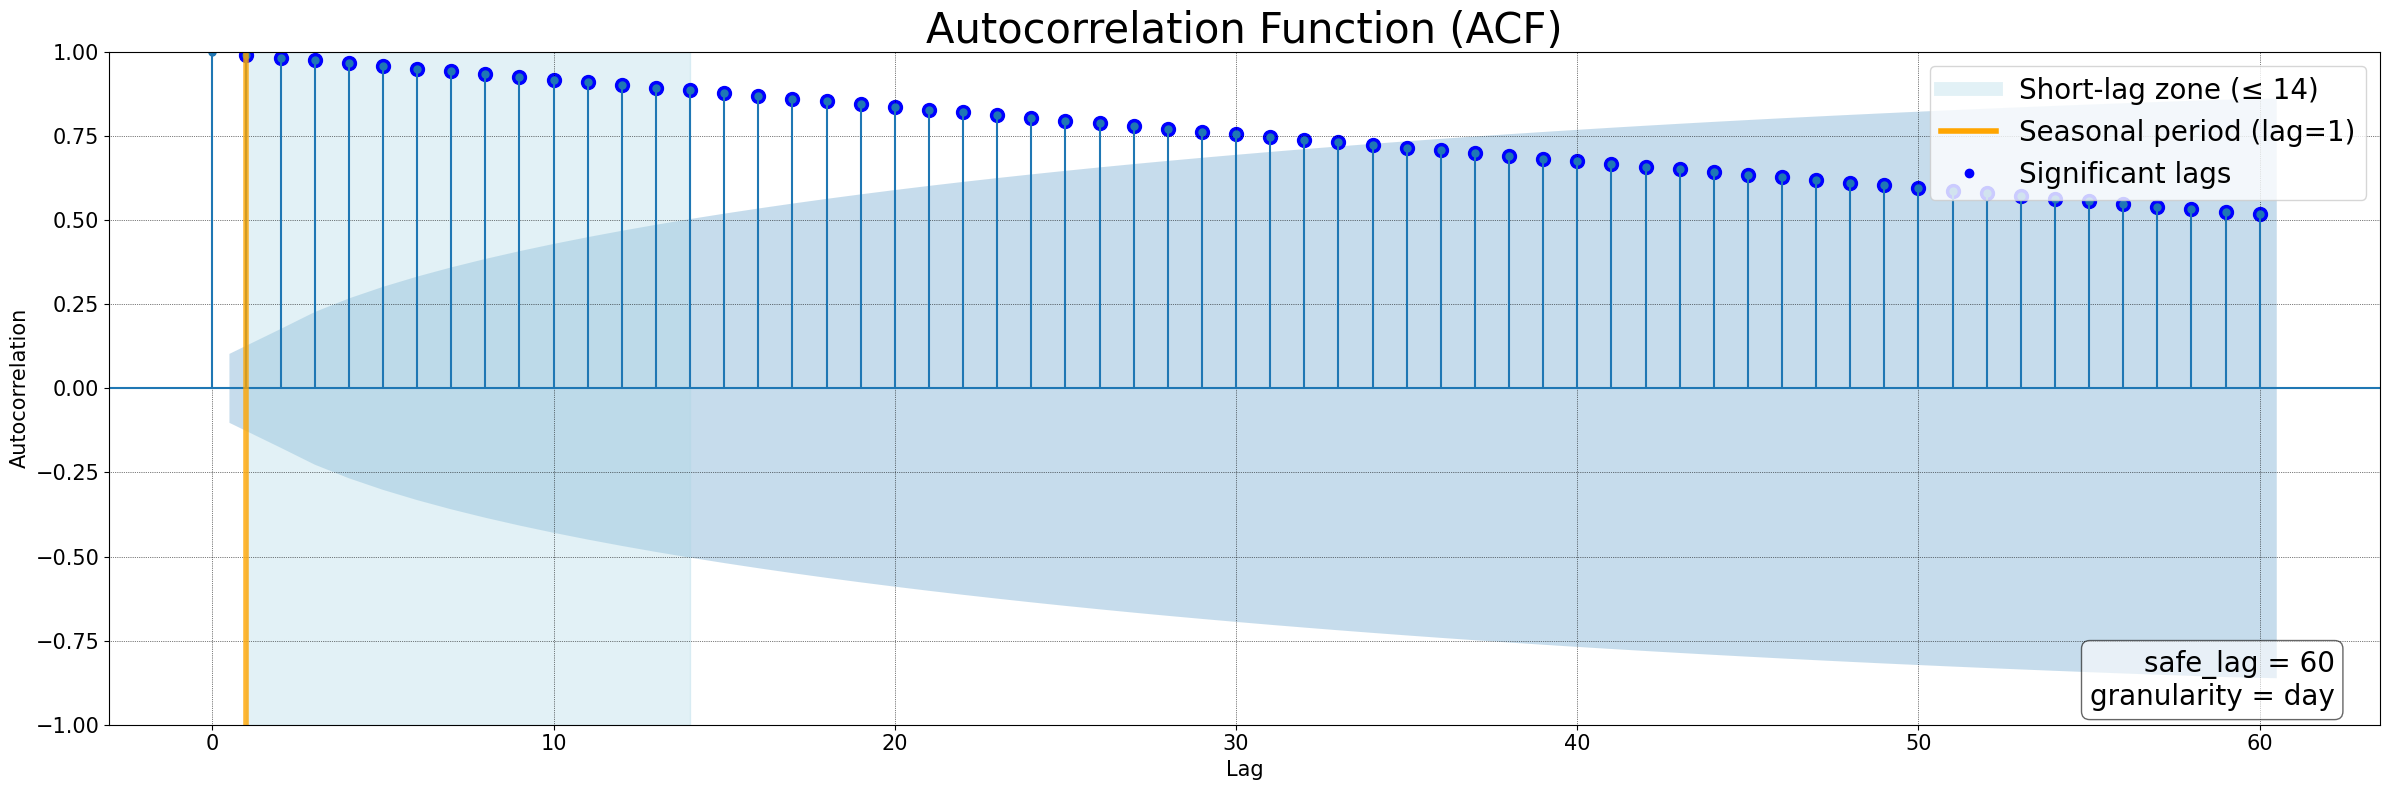

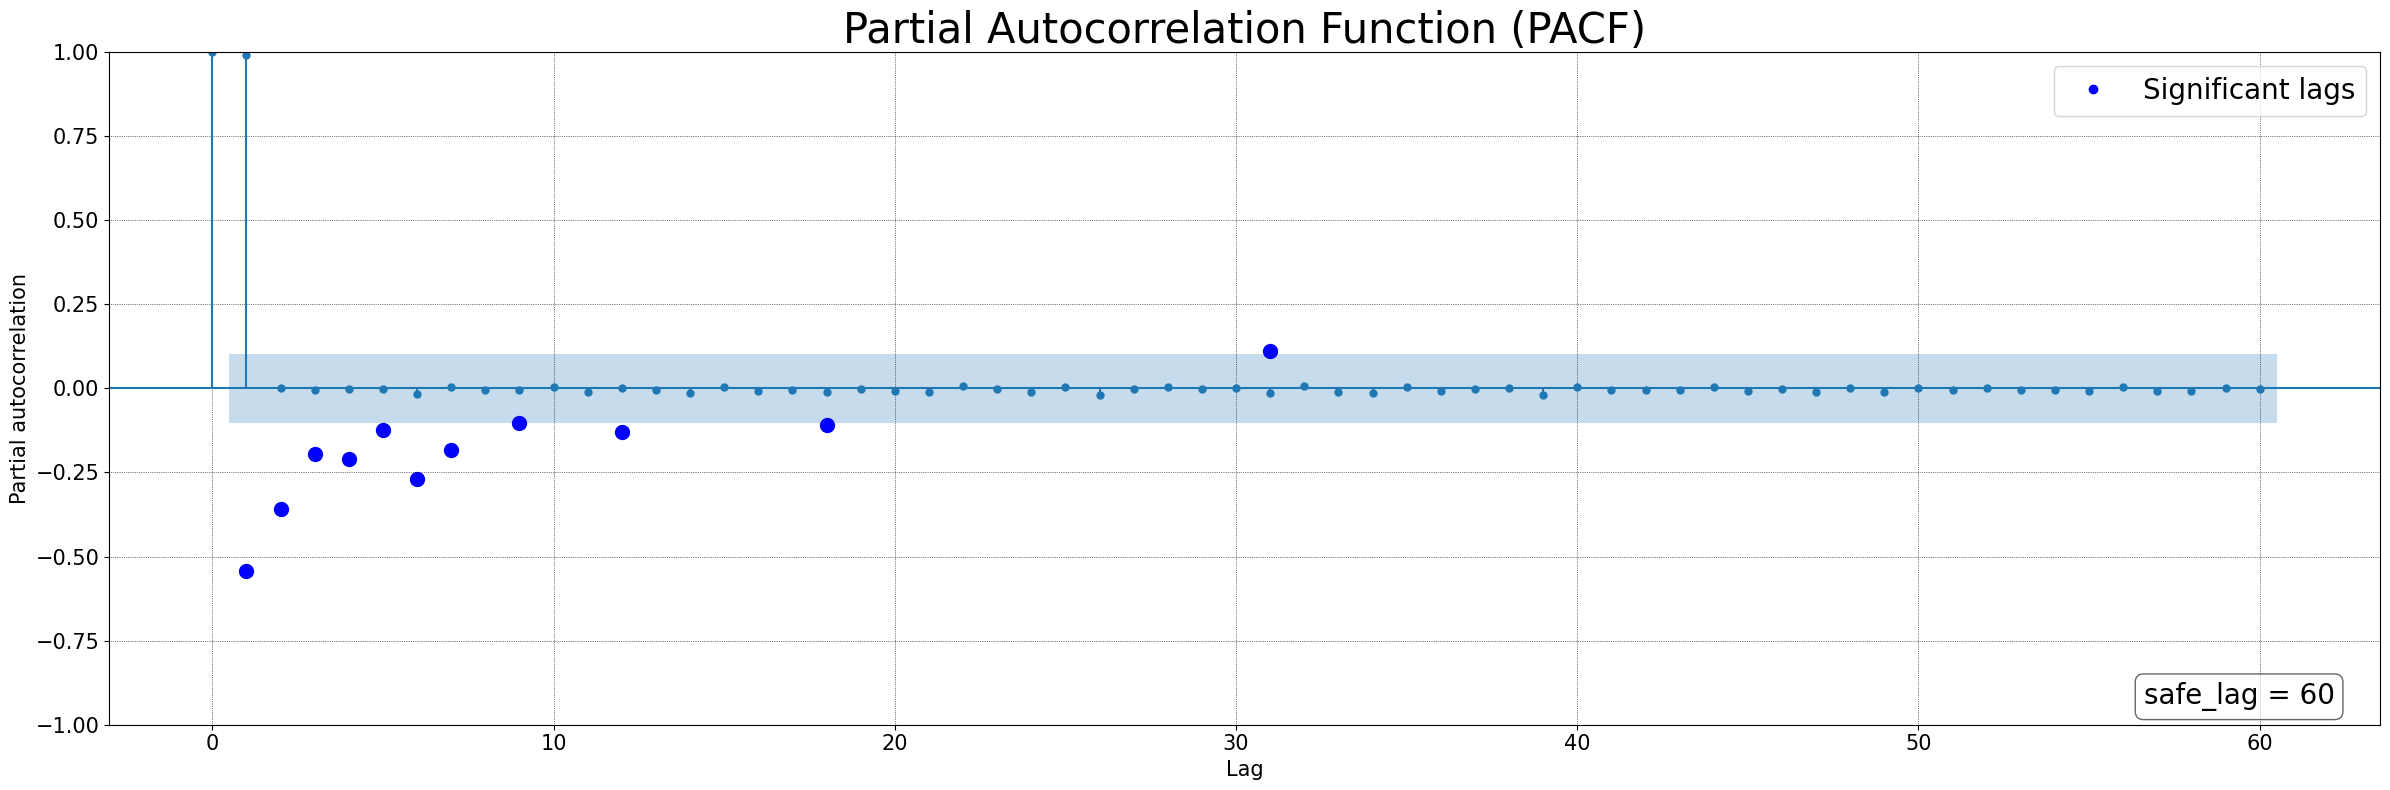

In [13]:
print("STEP 6) AUTOCORRELATION ANALYSIS")

# Copy previous time-series
df_timeseries_S6 = df_timeseries_S3.copy()
period_S6 = period_S3
suggested_d  = diff_count_S4
df_stacionary_timeseries_for_pacf_S6 = df_stationary_timeseries_S4.copy() # Use stationary series from STEP 4 to identify AR order

# Set frequency for ARIMA based on granularity
freq = get_freq_from_granularity(granularity)

if freq is not None:
    try:
        df_timeseries_S6 = df_timeseries_S6.asfreq(freq)
        log(f"Applied pandas frequency '{freq}' to series for ARIMA modeling.", level=1, type="INFO")
    except Exception as e:
        log(f"Could not apply frequency '{freq}': {e}", level=1, type="WARNING")
else:
    log(f"No valid pandas freq for granularity='{granularity}', ARIMA frequency skipped.", level=1, type="WARNING")

# If series is almost constant → no meaningful ACF/PACF
if df_timeseries_S6.std() < 1e-8:
    log("ACF/PACF analysis: Time-series is almost constant → no meaningful autocorrelation.", level=1, type="WARNING")

else:
    # Get recommended lag based on granularity
    recommended_lag = get_recommended_lag(granularity)
    # Limit by available data
    safe_lag = min(recommended_lag, len(df_timeseries_S6) - 2)
    # Log chosen lag
    log(f"Used safe_lag = {safe_lag} (recommended={recommended_lag}, granularity={granularity})", level=1, type="INFO")
    # Compute confidence (95%) limit for significance bands
    conf_limit = 1.96 / np.sqrt(len(df_timeseries_S6))

    # -------------------------------------------
    # ACF BEHAVIOUR
    # -------------------------------------------
    # Compute numerical ACF values
    acf_vals = acf(df_timeseries_S6, nlags=safe_lag, fft=True, missing="drop")
    # Build list of significant ACF lags
    significant_acf_lags = []
    seasonal_peaks_S6 = []
    for lag in range(1, len(acf_vals)):
        val = acf_vals[lag]
        if abs(val) > conf_limit:
            significant_acf_lags.append(lag)
    if len(significant_acf_lags) == 0:
        log("ACF analysis: No significant autocorrelation detected → series close to white noise.", level=1, type="INFO")
    else:
        log(f"ACF analysis: Significant autocorrelation at lags {significant_acf_lags}.", level=1, type="INFO")
        # Check short-lag ACF persistence (trend indicator)
        short_lags = []
        for lag in significant_acf_lags:
            if lag <= min(get_short_lag_cutoff(granularity), safe_lag):
                short_lags.append(lag)
        if len(short_lags) > 0:
            log("ACF analysis: High short-lag autocorrelation → possible trend or strong persistence.", level=1, type="INFO")
        # Check for seasonal multiples
        if (period_S6 is not None) and (period_S6 <= safe_lag):
            seasonal_peaks = []
            max_k = safe_lag // period_S6
            for k in range(1, max_k + 1):
                lag = k * period_S6
                if lag in significant_acf_lags:
                    seasonal_peaks.append(lag)
            seasonal_peaks_clean_print = []        
            for l in seasonal_peaks:
                seasonal_peaks_clean_print.append(int(l))
            if len(seasonal_peaks) > 0:
                seasonal_peaks_S6 = seasonal_peaks.copy()
                log(f"ACF analysis: Significant seasonal peaks at lags {seasonal_peaks_clean_print} → strong seasonality.", level=1, type="SUCCESS")

    # -------------------------------------------
    # PACF BEHAVIOUR
    # -------------------------------------------
    # Compute numerical PACF values
    pacf_vals = pacf(df_stacionary_timeseries_for_pacf_S6, nlags=safe_lag, method="ywm")
    # Build list of significant PACF lags
    significant_pacf_lags = []
    for lag in range(1, len(pacf_vals)):
        val = pacf_vals[lag]
        if abs(val) > conf_limit:
            significant_pacf_lags.append(lag)
    if len(significant_pacf_lags) == 0:
        suggested_p = 0
        log("PACF analysis: No significant partial autocorrelation detected.", level=1, type="INFO")
    else:
        log(f"PACF analysis: Significant PACF lags detected {significant_pacf_lags}.", level=1, type="INFO")
        # Keep non-seasonal PACF lags
        non_seasonal_pacf = []
        for lag in significant_pacf_lags:
            if (period_S6 is None) or (lag % period_S6 != 0):
                non_seasonal_pacf.append(lag)
        if len(non_seasonal_pacf) > 0:
            suggested_p = non_seasonal_pacf[0]
            log(f"PACF analysis: First significant non-seasonal lag = {suggested_p} → candidate AR order p ≈ {suggested_p}.", level=1, type="INFO")
        else:
            suggested_p = 0
    # -------------------------------------------
    # MODEL ORDER SUGGESTION (AR / MA)
    # -------------------------------------------
    if len(significant_acf_lags) > 0:
        suggested_q = significant_acf_lags[0]
    else:
        suggested_q = 0
    # Start from suggested values
    candidate_orders = [(suggested_p, suggested_d, suggested_q)]
    # If suggested_p = 0, also try p = 1 as alternative
    if suggested_p == 0:
        candidate_orders.append((1, suggested_d, suggested_q))
    best_aic = np.inf
    best_order = None
    for (p_try, d_try, q_try) in candidate_orders:
        try:
            model_try = ARIMA(df_timeseries_S6, order=(p_try, d_try, q_try))
            result_try = model_try.fit()
            if result_try.aic < best_aic:
                best_aic = result_try.aic
                best_order = (p_try, d_try, q_try)
        except Exception as e:
            log(f"ARIMA({p_try},{d_try},{q_try}) could not be fitted: {e}", type="WARNING")

    if best_order is not None:
        suggested_p, suggested_d, suggested_q = best_order
        log(f"Final ARIMA order suggestion: (p,d,q)=({suggested_p},{suggested_d},{suggested_q}) after AIC-checked refinement (best AIC={best_aic:.2f}).", level=1, type="INFO", bold=True)

    # -------------------------------------------
    # PLOT ACF
    # -------------------------------------------
    fig_acf, ax_acf = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
    plot_acf(df_timeseries_S6, lags=safe_lag, ax=ax_acf)
    ax_acf.set_title(label="Autocorrelation Function (ACF)", fontsize=plot_title_font_size)
    ax_acf.set_xlabel(xlabel="Lag", fontsize=plot_label_font_size)
    ax_acf.set_ylabel(ylabel="Autocorrelation", fontsize=plot_label_font_size)
    ax_acf.tick_params(labelsize=plot_tick_font_size)
    ax_acf.grid(True, linestyle="dotted", linewidth=0.5, color="black")
    # Build manual legend to avoid statsmodels overwriting handles
    handles, labels = [], []
    # Highlight short-lag zone (trend indicator)
    short_cutoff = min(get_short_lag_cutoff(granularity), safe_lag)
    ax_acf.axvspan(
        xmin=1,
        xmax=short_cutoff,
        color="lightblue",
        alpha=0.35,
        label=f"Short-lag zone (≤ {short_cutoff})"
    )
    handles.append(plt.Line2D([0], [0], color="lightblue", linewidth=10, alpha=0.35))
    labels.append(f"Short-lag zone (≤ {short_cutoff})")
    # Mark seasonal period (if applicable)
    if (period_S6 is not None) and (period_S6 <= safe_lag):
        ax_acf.axvline(
            x=period_S6,
            color="orange",
            linestyle="-",
            linewidth=4.0,
            alpha=0.8,
            label=f"Seasonal period (lag={period_S6})"
        )
        handles.append(plt.Line2D([0], [0], color="orange", linewidth=4))
        labels.append(f"Seasonal period (lag={period_S6})")
    # Mark significant ACF lags (points)
    if len(significant_acf_lags) > 0:
        ax_acf.scatter(
            significant_acf_lags,
            [acf_vals[lag] for lag in significant_acf_lags],
            color="blue",
            s=100,
            label="Significant lags"
        )
        handles.append(plt.Line2D([0], [0], marker="o", color="blue", linestyle="None"))
        labels.append("Significant lags")
    # Info text box
    ax_acf.text(
        0.98, 0.02,
        f"safe_lag = {safe_lag}\n"
        f"granularity = {granularity}",
        ha='right',
        va='bottom',
        transform=ax_acf.transAxes,
        fontsize=plot_text_font_size,
        bbox=dict(boxstyle="round", fc="white", alpha=0.6)
    )
    # Show legend and plot
    ax_acf.legend(handles, labels, loc="upper right", fontsize=plot_text_font_size)
    plt.tight_layout()
    plt.show()

    # -------------------------------------------
    # PLOT PACF
    # -------------------------------------------
    fig_pacf, ax_pacf = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
    plot_pacf(df_timeseries_S6, lags=safe_lag, ax=ax_pacf)
    ax_pacf.set_title(label="Partial Autocorrelation Function (PACF)", fontsize=plot_title_font_size)
    ax_pacf.set_xlabel(xlabel="Lag", fontsize=plot_label_font_size)
    ax_pacf.set_ylabel(ylabel="Partial autocorrelation", fontsize=plot_label_font_size)
    ax_pacf.tick_params(labelsize=plot_tick_font_size)
    ax_pacf.grid(True, linestyle="dotted", linewidth=0.5, color="black")
    # Build manual legend to avoid statsmodels overwriting handles
    handles, labels = [], []
    # Mark significant PACF lags (points)
    if len(significant_pacf_lags) > 0:
        ax_pacf.scatter(
            significant_pacf_lags,
            [pacf_vals[lag] for lag in significant_pacf_lags],
            color="blue",
            s=100,
            label="Significant lags"
        )
        handles.append(plt.Line2D([0], [0], marker="o", color="blue", linestyle="None"))
        labels.append("Significant lags")
    # Info text box
    ax_pacf.text(
        0.98, 0.02,
        f"safe_lag = {safe_lag}",
        ha='right',
        va='bottom',
        transform=ax_pacf.transAxes,
        fontsize=plot_text_font_size,
        bbox=dict(boxstyle="round", fc="white", alpha=0.6)
    )
    # Show legend and plot
    ax_pacf.legend(handles, labels, loc="upper right", fontsize=plot_text_font_size)
    plt.tight_layout()
    plt.show()

## STEP 7 - PREDICTION MODEL

In [14]:
prediction_horizon = 360

STEP 7) PREDICTION MODEL
• ℹ️ ARIMA (manual): selected order (p,d,q)=(1,1,1)
• ℹ️ AUTO-ARIMA: selected order (p,d,q)=(1,1,1) with seasonal=False, m=1
• ✅ ARIMA vs AUTO-ARIMA: Orders MATCH


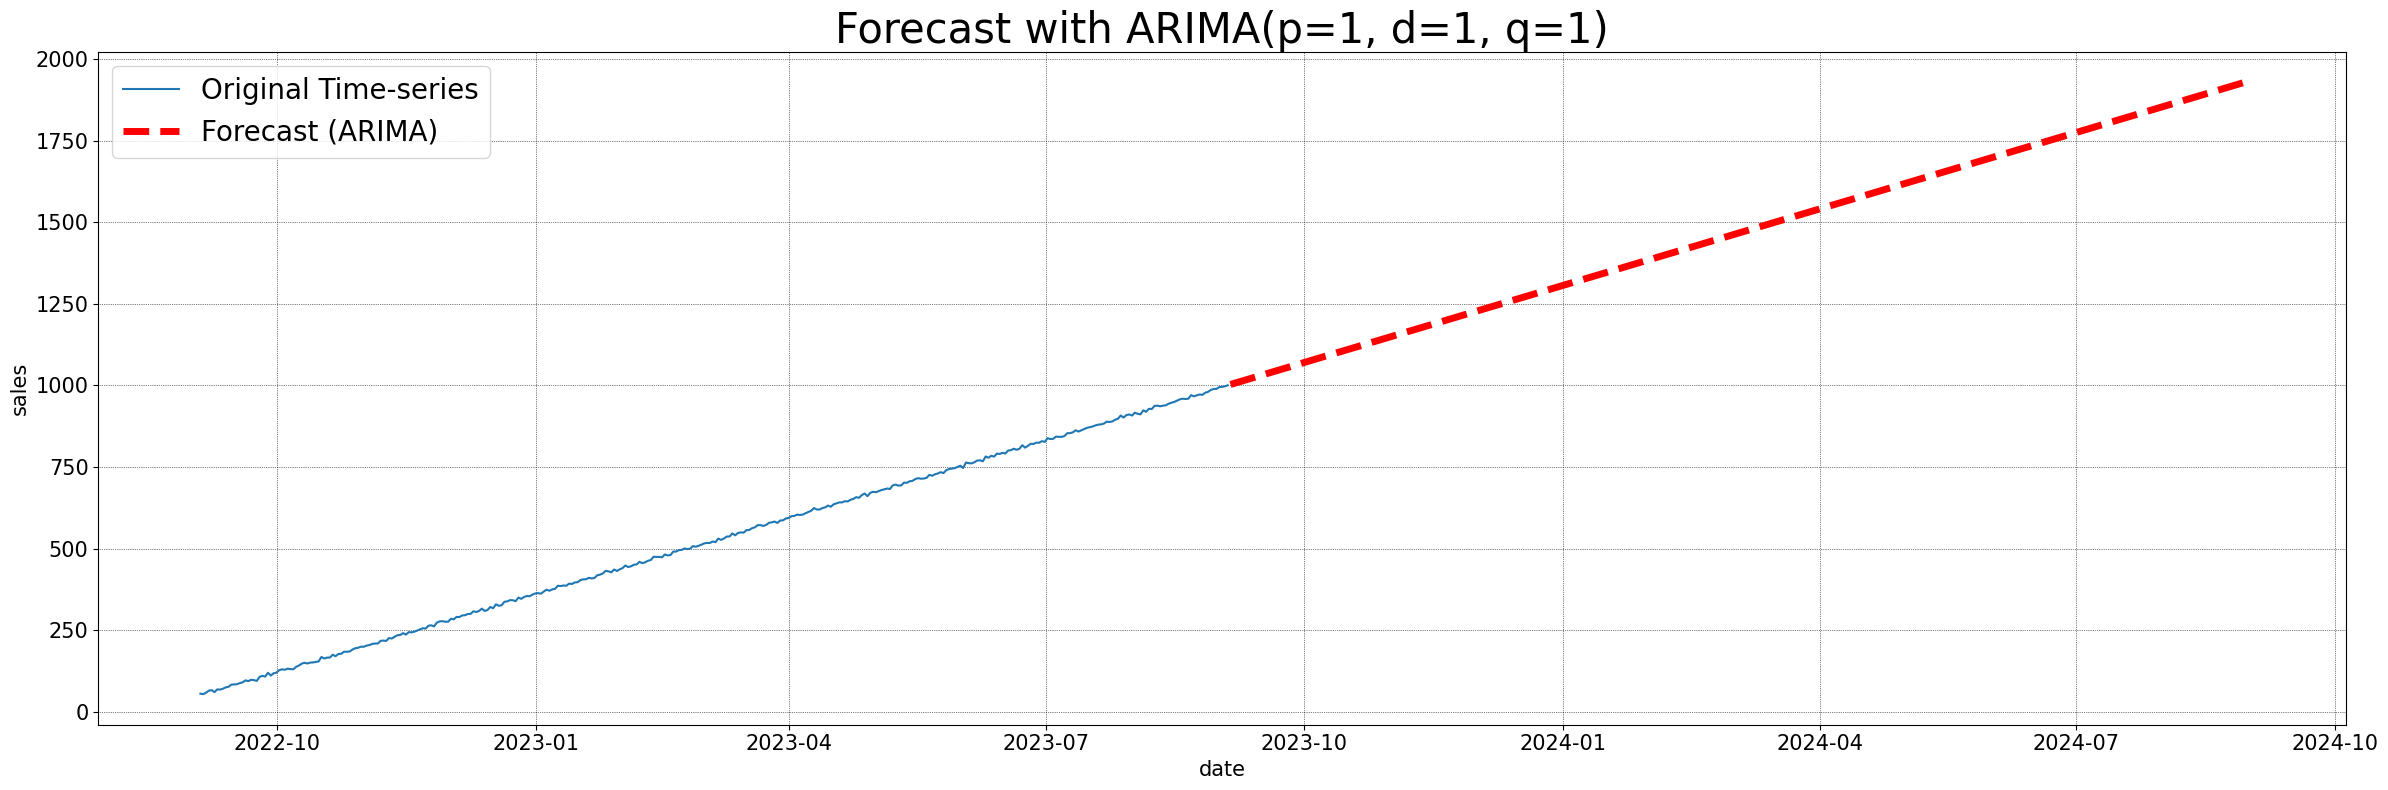

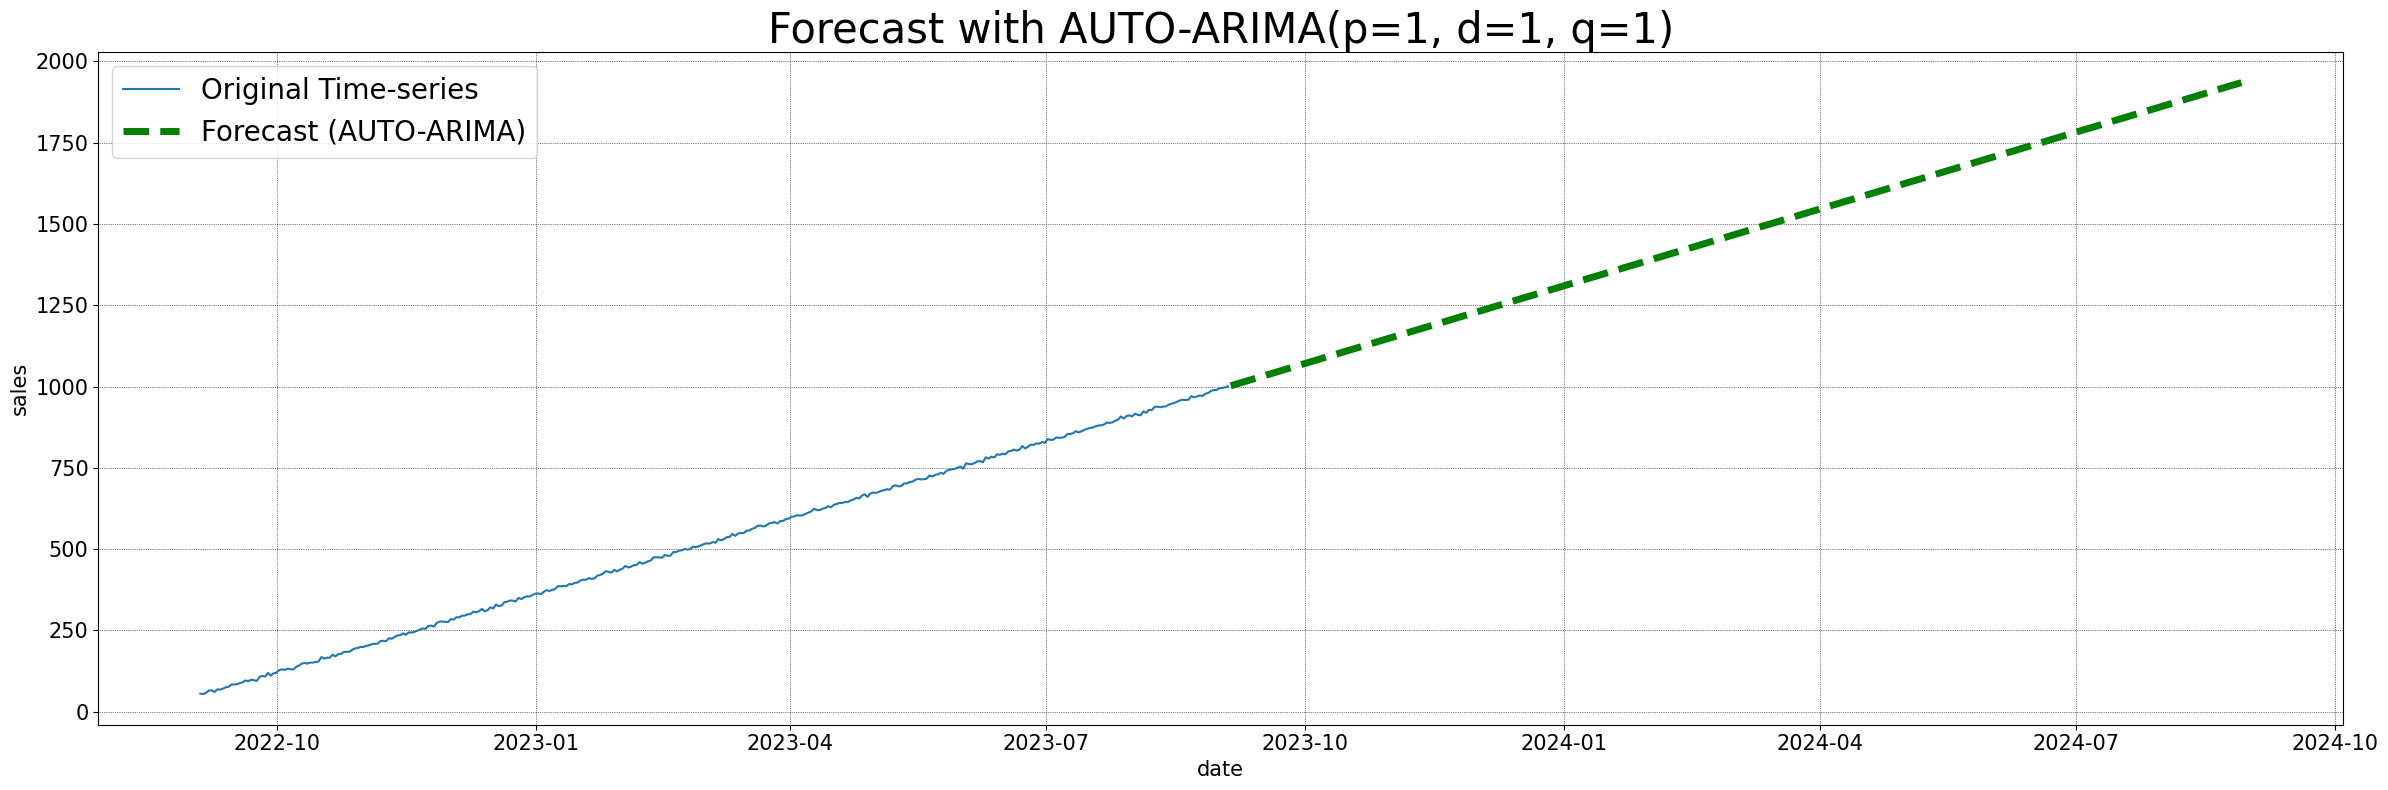

In [15]:
print("STEP 7) PREDICTION MODEL")

# Copy previous time-series
df_timeseries_S7 = df_timeseries_S6.copy()
period_S7 = period_S6
seasonal_peaks_S7 = seasonal_peaks_S6

# ======================================================
#  ARIMA MODEL WITH SUGGESTED VALUES
# ======================================================
# Instance ARIMA model
arima_model = ARIMA(endog = df_timeseries_S7, order = (suggested_p, suggested_d, suggested_q))
# Train ARIMA model
arima_result = arima_model.fit()
# Predict with trained ARIMA model
prediction_ARIMA = arima_result.predict(start  = len(df_timeseries_S7), end= len(df_timeseries_S7) + prediction_horizon)

# ======================================================
#  AUTO ARIMA
# ======================================================
# Decide seasonal behaviour for auto_arima
auto_arima_m = get_auto_arima_m(period=period_S7,seasonal_peaks = seasonal_peaks_S6)
if auto_arima_m > 1:
    auto_arima_seasonal = True
else:
    auto_arima_seasonal = False
# Instance AUTO ARIMA model
auto_arima_model = auto_arima(y=df_timeseries_S7, seasonal = auto_arima_seasonal, trace = False, m = auto_arima_m)
# Retrieve orders
auto_p, auto_d, auto_q = auto_arima_model.order
# Predict with trained AUTO ARIMA model
prediction_AUTO_ARIMA = auto_arima_model.predict(prediction_horizon)

# ======================================================
#  COMPARISON
# ======================================================
log(f"ARIMA (manual): selected order (p,d,q)=({suggested_p},{suggested_d},{suggested_q})", level=1, type="INFO")
log(f"AUTO-ARIMA: selected order (p,d,q)=({auto_p},{auto_d},{auto_q}) with seasonal={auto_arima_seasonal}, m={auto_arima_m}", level=1, type="INFO")

if (suggested_p == auto_p) and (suggested_d == auto_d) and (suggested_q == auto_q):
    log(f"ARIMA vs AUTO-ARIMA: Orders MATCH", level=1, type="SUCCESS", bold=True)
else:
    log(f"ARIMA vs AUTO-ARIMA: Orders DO NOT MATCH", level=1, type="WARNING", bold=True)

# ======================================================
#  FORECAST PLOT — ARIMA
# ======================================================
fig_arima, ax_arima = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
# Plot original series
ax_arima.plot(df_timeseries_S7, label="Original Time-series")
# Plot ARIMA forecast
ax_arima.plot(prediction_ARIMA, label="Forecast (ARIMA)", color="red", linewidth=5, linestyle="dashed")
# Title, labels, ticks and legend
ax_arima.set_title(label=f"Forecast with ARIMA(p={suggested_p}, d={suggested_d}, q={suggested_q})", fontsize=plot_title_font_size)
ax_arima.set_xlabel(xlabel=df_timeseries_S7.index.name, fontsize=plot_label_font_size)
ax_arima.set_ylabel(ylabel=df_timeseries_S7.name, fontsize=plot_label_font_size)
ax_arima.tick_params(labelsize=plot_tick_font_size)
ax_arima.legend(fontsize=plot_text_font_size)
ax_arima.grid(True, linestyle="dotted", linewidth=0.5, color="black")
# Show plot
plt.tight_layout()
plt.show()

# ======================================================
#  FORECAST PLOT — AUTO ARIMA
# ======================================================
fig_auto, ax_auto_arima = plt.subplots(nrows=1, ncols=1, figsize=(2 * figWidth_unit, 1 * figHeight_unit))
# Plot original series
ax_auto_arima.plot(df_timeseries_S7, label="Original Time-series")
# Plot AUTO-ARIMA forecast
ax_auto_arima.plot(prediction_AUTO_ARIMA, label="Forecast (AUTO-ARIMA)", color="green", linewidth=5, linestyle="dashed")
# Title, labels, ticks and legend
ax_auto_arima.set_title(label=f"Forecast with AUTO-ARIMA(p={auto_p}, d={auto_d}, q={auto_q})", fontsize=plot_title_font_size)
ax_auto_arima.set_xlabel(xlabel=df_timeseries_S7.index.name, fontsize=plot_label_font_size)
ax_auto_arima.set_ylabel(ylabel=df_timeseries_S7.name, fontsize=plot_label_font_size)
ax_auto_arima.tick_params(labelsize=plot_tick_font_size)
ax_auto_arima.legend(fontsize=plot_text_font_size)
ax_auto_arima.grid(True, linestyle="dotted", linewidth=0.5, color="black")
# Show plot
plt.tight_layout()
plt.show()

## STEP 8 - SAVE MODELS

In [16]:
models_output_path = "../models/"   # Folder where models will be saved
rev_to_use = 0

In [17]:
print("STEP 8) SAVE MODELS")

arima_filename = models_output_path + f"ARIMA_rev{rev_to_use}.sav"
dump(arima_result, open(arima_filename, "wb"))
log(f"Model saved: {arima_filename}", level=1, type="SUCCESS")

auto_arima_filename = models_output_path + f"AUTO_MANUAL_rev{rev_to_use}.sav"
dump(auto_arima_model, open(auto_arima_filename, "wb"))
log(f"Model saved: {auto_arima_filename}", level=1, type="SUCCESS")

STEP 8) SAVE MODELS
• ✅ Model saved: ../models/ARIMA_rev0.sav
• ✅ Model saved: ../models/AUTO_MANUAL_rev0.sav
